In [36]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az

In [37]:
def calc_ar_step(lag_coefs, n_eqs, n_lags, df):
    ars = []
    for j in range(n_eqs):
        ar = pm.math.sum(
            [
                pm.math.sum(lag_coefs[j, i] * df.values[n_lags - (i + 1) : -(i + 1)], axis=-1)
                for i in range(n_lags)
            ],
            axis=0,
        )
        ars.append(ar)
    beta = pm.math.stack(ars, axis=-1)

    return beta

def make_model(n_lags, n_eqs, df, priors, mv_norm=True, prior_checks=True):
    coords = {
        "lags": np.arange(n_lags) + 1,
        "equations": df.columns.tolist(),
        "cross_vars": df.columns.tolist(),
        "time": [x for x in df.index[n_lags:]],
    }

    with pm.Model(coords=coords) as model:
        lag_coefs = pm.Normal(
            "lag_coefs",
            mu=priors["lag_coefs"]["mu"],
            sigma=priors["lag_coefs"]["sigma"],
            dims=["equations", "lags", "cross_vars"],
        )
        data_obs = pm.Data("data_obs", df.values[n_lags:], dims=["time", "equations"])

        betaX = calc_ar_step(lag_coefs, n_eqs, n_lags, df)
        betaX = pm.Deterministic(
            "betaX",
            betaX,
            dims=[
                "time",
                "equations"
            ],
        )
        mean = betaX
        trace = pm.sample(2000, return_inferencedata=True, chains=4)
        
        if mv_norm:
            n = df.shape[1]
            ## Under the hood the LKJ prior will retain the correlation matrix too.
            noise_chol, _, _ = pm.LKJCholeskyCov(
                "noise_chol",
                eta=priors["noise_chol"]["eta"],
                n=n,
                sd_dist=pm.HalfNormal.dist(sigma=priors["noise_chol"]["sigma"]),
            )
            obs = pm.MvNormal(
                "obs", mu=mean, chol=noise_chol, observed=data_obs, dims=["time", "equations"]
            )
        else:
            ## This is an alternative likelihood that can recover sensible estimates of the coefficients
            ## But lacks the multivariate correlation between the timeseries.
            sigma = pm.HalfNormal("noise", sigma=priors["noise"]["sigma"], dims=["equations"])
            obs = pm.Normal(
                "obs", mu=mean, sigma=sigma, observed=data_obs, dims=["time", "equations"]
            )

        if prior_checks:
            idata = pm.sample_prior_predictive()
            return model, idata, trace
        else:
            idata = pm.sample_prior_predictive()
            idata.extend(pm.sample(draws=2000, random_seed=130))
            pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=19260817)
    return model, idata, trace

In [38]:
data = pd.read_csv("mydata_clean.csv")

In [39]:
names = ["real_GDP", "real_private_consumption", "real_government_expenditure", "real_government_revenue", "Real Wages", "real_private_non_residential_investment", "Interest Rate", "Adjusted Reserves", "PPIC", "gdp_deflator"]

In [40]:
n_lags = 6
n_eqs = 10
priors = {
    "lag_coefs": {"mu": 0, "sigma": 5},
    "noise_chol": {"eta": 1, "sigma": 1},
    "noise": {"sigma": 1},
}

d:\miniforge3\envs\py311\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 21 seconds.
Sampling: [lag_coefs, noise_chol, obs]


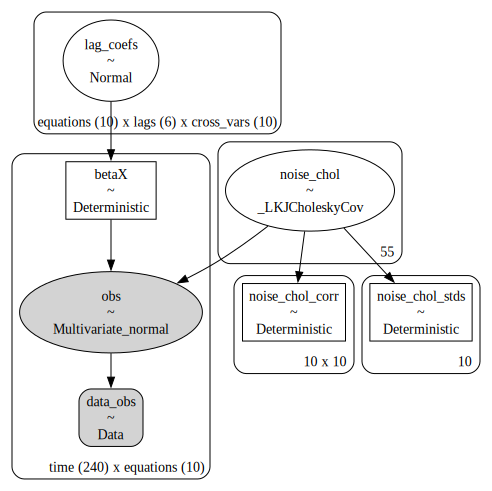

In [41]:
model, idata, trace = make_model(n_lags, n_eqs, data[names], priors)
pm.model_to_graphviz(model)

In [42]:
az.summary(idata, var_names=["lag_coefs"])

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"lag_coefs[real_GDP, 1, real_GDP]",-0.074,4.982,-10.062,8.638,0.234,0.165,449.0,399.0,NaN
"lag_coefs[real_GDP, 1, real_private_consumption]",0.123,5.107,-9.856,9.174,0.232,0.154,491.0,514.0,NaN
"lag_coefs[real_GDP, 1, real_government_expenditure]",-0.165,5.071,-9.337,8.827,0.226,0.150,510.0,488.0,NaN
"lag_coefs[real_GDP, 1, real_government_revenue]",-0.159,5.030,-10.756,7.724,0.221,0.141,520.0,491.0,NaN
"lag_coefs[real_GDP, 1, Real Wages]",-0.290,4.994,-8.852,10.105,0.224,0.159,491.0,473.0,NaN
...,...,...,...,...,...,...,...,...,...
"lag_coefs[gdp_deflator, 6, real_private_non_residential_investment]",-0.149,4.989,-9.219,8.887,0.235,0.161,452.0,461.0,NaN
"lag_coefs[gdp_deflator, 6, Interest Rate]",0.057,5.057,-9.034,9.478,0.219,0.156,531.0,473.0,NaN
"lag_coefs[gdp_deflator, 6, Adjusted Reserves]",0.156,4.947,-8.686,9.113,0.222,0.163,500.0,500.0,NaN
"lag_coefs[gdp_deflator, 6, PPIC]",-0.377,5.037,-9.585,9.063,0.227,0.167,494.0,409.0,NaN


In [43]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> constant_data